# Building  Residual Networks
### Packages

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras import Model, Sequential
import matplotlib.pyplot as plt
from matplotlib.image import imread
np.random.seed(1)
tf.random.set_seed(2)

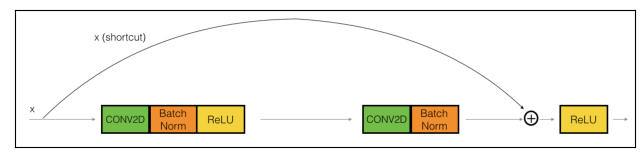

In [12]:
# Load the image from file
img = imread('images/idblock_kiank.png')
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)
plt.yticks([])
plt.xticks([])
plt.show()

### The Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<!-- <img src="images/idblock_kiank.png" style="width:650px;height:150px;" />  -->
<img src="https://github.com/makhmudjumanazarov/Residual-Network-Architectures-ResNet34-and-ResNet50-/raw/main/Images/idblock_kiank.png" style="width:650px;height:150px;" />



<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." 

You'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images\idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    X = Activation('relu')(X) 

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 

    return X

### The Convolutional Block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>



In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X) 

    ## Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Building Your ResNet Model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [ ]:
def ResNet50(input_shape, classes):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    ## Stage 3 
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2) 
    X = identity_block(X, 3, [128, 128, 512]) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    ## Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024],s=2) 
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048],s=2) 
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL. Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X) 
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = ResNet50(input_shape=(64, 64, 3), classes=6)
print(model.summary())

### Import ResNet50 from Tensorflow Applications

In [ ]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    input_shape= (64, 64, 3),
    weights='imagenet'
)
resnet50.summary()
model_res_50 = Sequential()
for layer in resnet50.layers:
    layer.trainable = False
model_res_50.add(resnet50)
model_res_50.add(Flatten())
model_res_50.add(Dense(activation = "relu", units = 6))
# model_res_50.summary()

### *👆👆👆 Compare ResNet50 Architecture from scratch and Import ResNet50 from Tensorflow Applications*

## Building Your ResNet Model (34 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network.

<img src="images/ResNet34.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>ResNet-34 model</b> </center></caption>

The details of this ResNet-34 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The 3 Res_blocks use two sets of filters of size [64,64], "f" is 3 and strides = (1, 1).
- Stage 3:
    - The Res_block use two sets of filters of size [128,128], "f" is 3 and strides = (2, 2).
    - The 3 Res_blocks use two sets of filters of size [128,128], "f" is 3 and strides = (1, 1).
- Stage 4:
    - The Res_block use two sets of filters of size [256,256], "f" is 3 and strides = (2, 2).
    - The 5 Res_blocks use two sets of filters of size [256,256], "f" is 3 and strides = (1, 1).
- Stage 5:
    - The Res_block use two sets of filters of size [512,512], "f" is 3 and strides = (2, 2).
    - The 2 Res_blocks use two sets of filters of size [512,512], "f" is 3 and strides = (1, 1).
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [ ]:
def Res_block(X, f, filters, s, training=True, initializer=glorot_uniform):
    
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(s, s), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of main path 
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X) 
    X = BatchNormalization(axis=3)(X, training=training)
    
    if s == 2:
        X_shortcut = Conv2D(F2, (1, 1), strides=(s, s), kernel_initializer=initializer(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet34(input_shape, classes):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = Res_block(X, f = 3, filters=[64, 64], s = 1)
    X = Res_block(X, f = 3, filters=[64, 64], s = 1)
    X = Res_block(X, f = 3, filters=[64, 64], s = 1)
    
    ## Stage 3
    X = Res_block(X, f = 3, filters=[128, 128], s = 2)
    X = Res_block(X, f = 3, filters=[128, 128], s = 1)
    X = Res_block(X, f = 3, filters=[128, 128], s = 1)
    X = Res_block(X, f = 3, filters=[128, 128], s = 1)
    
    ## Stage 4
    X = Res_block(X, f = 3, filters=[256, 256], s = 2)
    X = Res_block(X, f = 3, filters=[256, 256], s = 1)
    X = Res_block(X, f = 3, filters=[256, 256], s = 1)
    X = Res_block(X, f = 3, filters=[256, 256], s = 1)
    X = Res_block(X, f = 3, filters=[256, 256], s = 1)
    X = Res_block(X, f = 3, filters=[256, 256], s = 1)

    ## Stage 5
    X = Res_block(X, f = 3, filters=[512, 512], s = 2)
    X = Res_block(X, f = 3, filters=[512, 512], s = 1)
    X = Res_block(X, f = 3, filters=[512, 512], s = 1)

    ## AVGPOOL. Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X) 
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = ResNet34(input_shape=(64, 64, 3), classes=10)
print(model.summary())